In [ ]:
!pip install deepchem torch_geometric rdkit biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.4/552.4 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 46.1 MB/s eta 0:00:00


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import deepchem as dc
from torch_geometric.loader import DataLoader
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, ReLU, Sequential, BatchNorm1d, Dropout
from torch_geometric.nn import GINConv, global_add_pool, HeteroConv, SAGEConv, global_mean_pool
from torch_geometric.data import Data, HeteroData
from scipy.spatial import distance_matrix
from rdkit import Chem


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


GraphDock Functions

In [ ]:
def get_ligand_atoms_features(ligand_path):
    """Extract ligand atom features and 3D coordinates for GraphDock.

    Node features include:
    - Atom type (one-hot)
    - Degree
    - Formal charge
    - Hybridization
    - Aromaticity
    - Total Hs
    - Mass
    - Ring membership

    Returns:
        coords: N x 3 numpy array of 3D positions
        features: N x F numpy array of atom features
        atom_types: list of atomic numbers
    """
    if ligand_path.endswith('.pdb'):
        mol = Chem.MolFromPDBFile(str(ligand_path), removeHs=False)
    elif ligand_path.endswith('.mol2'):
        mol = Chem.MolFromMol2File(str(ligand_path), removeHs=False)
    else:
        mol = Chem.MolFromMolFile(str(ligand_path), removeHs=False)

    if mol is None:
        return None, None, None

    # Extract 3D coordinates of each atom
    conf = mol.GetConformer()
    coords = np.array([list(conf.GetAtomPosition(i)) for i in range(mol.GetNumAtoms())])

    features = []
    atom_types = []

    for atom in mol.GetAtoms():
        atom_num = atom.GetAtomicNum()
        atom_types.append(atom_num)

        # One-hot encoding of atom type
        atom_type_onehot = [0] * 11
        type_map = {6: 0, 7: 1, 8: 2, 16: 3, 15: 4, 9: 5, 17: 6, 35: 7, 53: 8, 1: 9}
        atom_type_onehot[type_map.get(atom_num, 10)] = 1

        # Combine all features into a single vector per atom
        feat = atom_type_onehot + [
            atom.GetDegree() / 6.0,       # normalized degree
            atom.GetFormalCharge(),       # integer charge
            int(atom.GetHybridization()) / 6.0,  # enum → normalized
            int(atom.GetIsAromatic()),    # 0 or 1
            atom.GetTotalNumHs() / 4.0,   # normalized H count
            atom.GetMass() / 100.0,       # normalized mass
            int(atom.IsInRing()),         # 0 or 1
        ]
        features.append(feat)

    return coords, np.array(features, dtype=np.float32), atom_types


def get_protein_atoms_features(protein_path):
    """Extract protein pocket atom features and 3D coordinates for GraphDock.

    Node features include:
    - Atom type (C, N, O, S)
    - Amino acid properties (hydrophobic, positive/negative, polar)
    - Backbone indicator

    Returns:
        coords: N x 3
        features: N x F
        residue_types: list of residue names
    """
    from Bio import PDB

    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("pocket", protein_path)

    coords = []
    features = []
    residue_types = []

    # Simplified amino acid property encoding
    aa_properties = {
        'ALA': [1, 0, 0], 'ARG': [0, 1, 1], 'ASN': [0, 0, 1], 'ASP': [0, -1, 1],
        'CYS': [1, 0, 1], 'GLN': [0, 0, 1], 'GLU': [0, -1, 1], 'GLY': [0, 0, 0],
        'HIS': [0, 0, 1], 'ILE': [1, 0, 0], 'LEU': [1, 0, 0], 'LYS': [0, 1, 1],
        'MET': [1, 0, 0], 'PHE': [1, 0, 0], 'PRO': [0, 0, 0], 'SER': [0, 0, 1],
        'THR': [0, 0, 1], 'TRP': [1, 0, 0], 'TYR': [0, 0, 1], 'VAL': [1, 0, 0],
    }

    for model in structure:
        for chain in model:
            for residue in chain:
                res_name = residue.get_resname()
                for atom in residue:
                    coords.append(atom.get_coord())
                    element = atom.element.strip()

                    # One-hot atom type
                    atom_type_onehot = [0] * 5
                    type_map = {'C': 0, 'N': 1, 'O': 2, 'S': 3}
                    atom_type_onehot[type_map.get(element, 4)] = 1

                    # Residue properties
                    res_props = aa_properties.get(res_name, [0, 0, 0])
                    is_backbone = int(atom.name in ['N', 'CA', 'C', 'O'])

                    feat = atom_type_onehot + res_props + [is_backbone]
                    features.append(feat)
                    residue_types.append(res_name)

    return np.array(coords), np.array(features, dtype=np.float32), residue_types


def compute_edge_features_graphdock(coord_i, coord_j, dist):
    """Compute edge features for GraphDock.

    Each edge feature vector (14D):
    - distance
    - 10 RBF (radial basis functions)
    - 3D direction unit vector
    """
    distance_feat = [dist]

    # Radial basis function expansion
    rbf_centers = np.linspace(0, 10, 10)
    rbf_gamma = 0.5
    rbf_feats = np.exp(-rbf_gamma * (dist - rbf_centers) ** 2).tolist()

    # 3D direction
    if dist > 0:
        direction = (coord_j - coord_i) / dist
        direction_feats = direction.tolist()
    else:
        direction_feats = [0.0, 0.0, 0.0]

    return distance_feat + rbf_feats + direction_feats


def create_graphdock_hetero_graph(ligand_path, protein_path, ligand_cutoff=5.0,
                                   protein_cutoff=6.0, interaction_cutoff=5.0):
    """Construct a heterogeneous graph for a ligand-protein complex.

    Node types: 'ligand', 'protein'
    Edge types:
        - 'lig_lig': ligand-ligand edges <= 5Å
        - 'prot_prot': protein-protein edges <= 6Å
        - 'interaction': ligand-protein edges <= 5Å
    """

    # --- Node features ---
    lig_coords, lig_feats, lig_types = get_ligand_atoms_features(ligand_path)
    if lig_coords is None:
        return None
    prot_coords, prot_feats, res_types = get_protein_atoms_features(protein_path)

    data = HeteroData()
    data['ligand'].x = torch.tensor(lig_feats, dtype=torch.float)
    data['ligand'].pos = torch.tensor(lig_coords, dtype=torch.float)
    data['ligand'].num_nodes = len(lig_coords)

    data['protein'].x = torch.tensor(prot_feats, dtype=torch.float)
    data['protein'].pos = torch.tensor(prot_coords, dtype=torch.float)
    data['protein'].num_nodes = len(prot_coords)

    # --- Ligand-ligand edges ---
    lig_dist_matrix = distance_matrix(lig_coords, lig_coords)
    lig_edges, lig_edge_feats = [], []
    for i in range(len(lig_coords)):
        for j in range(i + 1, len(lig_coords)):
            if lig_dist_matrix[i, j] <= ligand_cutoff:
                dist = lig_dist_matrix[i, j]
                edge_feat = compute_edge_features_graphdock(lig_coords[i], lig_coords[j], dist)
                # Bidirectional edges
                lig_edges += [[i, j], [j, i]]
                lig_edge_feats += [edge_feat, edge_feat]

    if lig_edges:
        data['ligand', 'lig_lig', 'ligand'].edge_index = torch.tensor(lig_edges, dtype=torch.long).t().contiguous()
        data['ligand', 'lig_lig', 'ligand'].edge_attr = torch.tensor(lig_edge_feats, dtype=torch.float)

    # --- Protein-protein edges ---
    prot_dist_matrix = distance_matrix(prot_coords, prot_coords)
    prot_edges, prot_edge_feats = [], []
    for i in range(len(prot_coords)):
        nearby = np.where(prot_dist_matrix[i] <= protein_cutoff)[0]
        for j in nearby:
            if i < j:
                dist = prot_dist_matrix[i, j]
                edge_feat = compute_edge_features_graphdock(prot_coords[i], prot_coords[j], dist)
                prot_edges += [[i, j], [j, i]]
                prot_edge_feats += [edge_feat, edge_feat]

    if prot_edges:
        data['protein', 'prot_prot', 'protein'].edge_index = torch.tensor(prot_edges, dtype=torch.long).t().contiguous()
        data['protein', 'prot_prot', 'protein'].edge_attr = torch.tensor(prot_edge_feats, dtype=torch.float)

    # --- Ligand-protein interaction edges ---
    cross_dist_matrix = distance_matrix(lig_coords, prot_coords)
    pl_edges, pl_edge_feats, lp_edges, lp_edge_feats = [], [], [], []
    for i in range(len(lig_coords)):
        for j in range(len(prot_coords)):
            if cross_dist_matrix[i, j] <= interaction_cutoff:
                dist = cross_dist_matrix[i, j]
                edge_feat = compute_edge_features_graphdock(lig_coords[i], prot_coords[j], dist)
                pl_edges.append([i, j])
                pl_edge_feats.append(edge_feat)
                # Reverse edge for heterograph
                edge_feat_rev = compute_edge_features_graphdock(prot_coords[j], lig_coords[i], dist)
                lp_edges.append([j, i])
                lp_edge_feats.append(edge_feat_rev)

    if pl_edges:
        data['ligand', 'interaction', 'protein'].edge_index = torch.tensor(pl_edges, dtype=torch.long).t().contiguous()
        data['ligand', 'interaction', 'protein'].edge_attr = torch.tensor(pl_edge_feats, dtype=torch.float)
        data['protein', 'interaction', 'ligand'].edge_index = torch.tensor(lp_edges, dtype=torch.long).t().contiguous()
        data['protein', 'interaction', 'ligand'].edge_attr = torch.tensor(lp_edge_feats, dtype=torch.float)

    return data


def process_pdbbind_with_graphdock(dc_dataset, ligand_cutoff=5.0,
                                    protein_cutoff=6.0, interaction_cutoff=5.0):
    """Convert an entire PDBBind dataset into GraphDock heterographs."""
    graph_data = []
    failed_count = 0

    for X, y, w, ids in tqdm(dc_dataset.iterbatches(batch_size=1, deterministic=True),
                             desc="Processing with GraphDock"):
        ligand_path = X[0][0]
        protein_path = X[0][1]

        try:
            hetero_data = create_graphdock_hetero_graph(
                ligand_path, protein_path, ligand_cutoff, protein_cutoff, interaction_cutoff
            )
            if hetero_data is None:
                failed_count += 1
                continue

            # Attach binding affinity label
            hetero_data.y = torch.tensor(y, dtype=torch.float)
            graph_data.append(hetero_data)
        except Exception:
            failed_count += 1
            continue

    print(f"\nProcessed {len(graph_data)} complexes successfully, Failed: {failed_count}")
    return graph_data


GraphDock Model

In [ ]:
class GraphDockModel(nn.Module):
    """
    GraphDock GNN model for predicting ligand-protein binding affinity.

    - Uses a heterogeneous graph with nodes: ligand atoms, protein atoms.
    - Edge types: ligand-ligand, protein-protein, ligand-protein interactions.
    - Each node has feature vectors extracted from chemical/structural info.
    - Each edge has features: distance, RBF expansion, 3D direction.
    """
    def __init__(self, ligand_feat_dim=18, protein_feat_dim=9, edge_feat_dim=14,
                 hidden_dim=128, num_layers=3, output_dim=1, dropout=0.2):
        super(GraphDockModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # --- Node embedding layers ---
        self.ligand_embedding = Sequential(
            Linear(ligand_feat_dim, hidden_dim), BatchNorm1d(hidden_dim), ReLU(),
            Dropout(dropout), Linear(hidden_dim, hidden_dim)
        )
        self.protein_embedding = Sequential(
            Linear(protein_feat_dim, hidden_dim), BatchNorm1d(hidden_dim), ReLU(),
            Dropout(dropout), Linear(hidden_dim, hidden_dim)
        )

        # --- Edge feature encoders ---
        # Each edge type has its own linear encoder to project 14D edge features → hidden_dim
        self.edge_encoders = nn.ModuleDict({
            'lig_lig': Linear(edge_feat_dim, hidden_dim),
            'prot_prot': Linear(edge_feat_dim, hidden_dim),
            'interaction': Linear(edge_feat_dim, hidden_dim),
        })

        # --- Heterogeneous GNN layers ---
        self.convs = nn.ModuleList()
        self.batch_norms = nn.ModuleDict()

        for layer in range(num_layers):
            conv_dict = {}
            # SAGEConv applied per edge type for message passing
            conv_dict[('ligand', 'lig_lig', 'ligand')] = SAGEConv(
                (hidden_dim, hidden_dim), hidden_dim, normalize=True
            )
            conv_dict[('protein', 'prot_prot', 'protein')] = SAGEConv(
                (hidden_dim, hidden_dim), hidden_dim, normalize=True
            )
            conv_dict[('ligand', 'interaction', 'protein')] = SAGEConv(
                (hidden_dim, hidden_dim), hidden_dim, normalize=True
            )
            conv_dict[('protein', 'interaction', 'ligand')] = SAGEConv(
                (hidden_dim, hidden_dim), hidden_dim, normalize=True
            )

            # HeteroConv aggregates messages across all edge types
            self.convs.append(HeteroConv(conv_dict, aggr='sum'))

            # BatchNorm for ligand/protein nodes per layer
            self.batch_norms[f'ligand_{layer}'] = BatchNorm1d(hidden_dim)
            self.batch_norms[f'protein_{layer}'] = BatchNorm1d(hidden_dim)

        # --- Prediction head ---
        # After GNN layers, ligand and protein embeddings are pooled and concatenated
        self.predictor = Sequential(
            Linear(hidden_dim * 2, hidden_dim),
            BatchNorm1d(hidden_dim),
            ReLU(),
            Dropout(dropout),
            Linear(hidden_dim, hidden_dim // 2),
            ReLU(),
            Dropout(dropout),
            Linear(hidden_dim // 2, output_dim)  # outputs binding affinity
        )

    def forward(self, data):
        # --- Embed nodes ---
        x_dict = {
            'ligand': self.ligand_embedding(data['ligand'].x),
            'protein': self.protein_embedding(data['protein'].x)
        }

        # --- Encode edge features ---
        edge_attr_dict = {}
        for edge_type in data.edge_types:
            if hasattr(data[edge_type], 'edge_attr'):
                # Map edge type to encoder
                if edge_type[1] == 'lig_lig':
                    encoder_key = 'lig_lig'
                elif edge_type[1] == 'prot_prot':
                    encoder_key = 'prot_prot'
                else:
                    encoder_key = 'interaction'
                edge_attr_dict[edge_type] = self.edge_encoders[encoder_key](
                    data[edge_type].edge_attr
                )

        # --- Message passing through GNN layers ---
        for layer_idx, conv in enumerate(self.convs):
            # x_dict_new: updated node embeddings per layer
            x_dict_new = conv(x_dict, data.edge_index_dict)
            # Apply batch norm + ReLU activation
            x_dict = {
                'ligand': F.relu(self.batch_norms[f'ligand_{layer_idx}'](x_dict_new['ligand'])),
                'protein': F.relu(self.batch_norms[f'protein_{layer_idx}'](x_dict_new['protein']))
            }

        # --- Global pooling to obtain graph-level embeddings ---
        # For batched graphs, get batch indices; otherwise default zeros
        ligand_batch = data['ligand'].batch if hasattr(data['ligand'], 'batch') else torch.zeros(
            data['ligand'].num_nodes, dtype=torch.long, device=x_dict['ligand'].device
        )
        protein_batch = data['protein'].batch if hasattr(data['protein'], 'batch') else torch.zeros(
            data['protein'].num_nodes, dtype=torch.long, device=x_dict['protein'].device
        )

        # Mean pooling per graph
        ligand_pooled = global_mean_pool(x_dict['ligand'], ligand_batch)
        protein_pooled = global_mean_pool(x_dict['protein'], protein_batch)

        # Concatenate ligand and protein embeddings → pass to predictor
        combined = torch.cat([ligand_pooled, protein_pooled], dim=1)
        return self.predictor(combined)


def train_graphdock_model(model, train_loader, val_loader, num_epochs=200, patience=25, lr=0.001, device='cpu'):
    """Training loop for GraphDock model.

    - Uses Adam optimizer with weight decay.
    - ReduceLROnPlateau scheduler based on validation loss.
    - Early stopping after 'patience' epochs without improvement.
    - Gradient clipping applied to stabilize training.
    """
    print(f"Using device: {device}")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10
    )

    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(num_epochs):
        # --- Training step ---
        model.train()
        train_losses = []
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            preds = model(batch).squeeze()
            targets = batch.y.squeeze().float().to(device)
            loss = F.mse_loss(preds, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_losses.append(loss.item())

        # --- Validation step ---
        model.eval()
        val_losses = []
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                preds = model(batch).squeeze()
                targets = batch.y.squeeze().float().to(device)
                loss = F.mse_loss(preds, targets)
                val_losses.append(loss.item())

        # Compute average losses
        train_loss_avg = sum(train_losses) / len(train_losses)
        val_loss_avg = sum(val_losses) / len(val_losses)

        # Adjust learning rate if validation loss plateaus
        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss_avg)
        new_lr = optimizer.param_groups[0]['lr']

        if new_lr != old_lr:
            print(f"Learning rate reduced to {new_lr}")

        # --- Early stopping logic ---
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                model.load_state_dict(best_model_state)
                break

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss_avg:.4f} - Val Loss: {val_loss_avg:.4f}")

    return model

Evaluation Function

In [ ]:
def evaluate_model(model, loader, device='cpu'):
    """Evaluate model and return metrics."""
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            preds = model(batch).squeeze().cpu().numpy()
            targets = batch.y.squeeze().cpu().numpy()

            if preds.ndim == 0:
                preds = np.array([preds])
            if targets.ndim == 0:
                targets = np.array([targets])

            predictions.extend(preds)
            actuals.extend(targets)

    actuals = np.array(actuals)
    predictions = np.array(predictions)

    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)

    return mse, rmse, r2, actuals, predictions

Main Execution

GPU available: Tesla T4
LOADING PDBBIND DATASET
Train: 3881, Valid: 485, Test: 486

USING GRAPHDOCK APPROACH

Processing training set...


Streaming output truncated to the last 5000 lines.
[21:59:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
Processing with GraphDock: 367it [01:08,  4.82it/s][21:59:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
Processing with GraphDock: 368it [01:08,  4.54it/s][21:59:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[21:59:27] Explicit valence for atom # 3 P, 6, is greater than permitted
[21:59:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
Processing with GraphDock: 370it [01:09,  5.15it/s][21:59:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
Processing with GraphDock: 371it [01:09,  3.39it/s][21:59:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.



Processed 2227 complexes successfully, Failed: 1654
Processing validation set...


Processing with GraphDock: 0it [00:00, ?it/s][22:11:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
Processing with GraphDock: 1it [00:00,  2.91it/s][22:11:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[22:11:57] Explicit valence for atom # 9 S, 7, is greater than permitted
[22:11:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[22:11:57] Explicit valence for atom # 4 C, 5, is greater than permitted
[22:11:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
Processing with GraphDock: 4it [00:00,  8.05it/s][22:11:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[22:11:57] Explicit valence for atom # 18 C, 5, is greater than permitted
[22:11:57] Warning: molecule is tagged as 2D, but at least one Z coordinate i


Processed 272 complexes successfully, Failed: 213
Processing test set...


Processing with GraphDock: 0it [00:00, ?it/s][22:13:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[22:13:33] Explicit valence for atom # 25 P, 7, is greater than permitted
[22:13:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
Processing with GraphDock: 2it [00:00,  4.96it/s][22:13:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[22:13:33] Explicit valence for atom # 0 P, 7, is greater than permitted
[22:13:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
Processing with GraphDock: 4it [00:00,  6.13it/s][22:13:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[22:13:34] Explicit valence for atom # 11 C, 5, is greater than permitted
[22:13:34] Warning: molecule is tagged as 2D, but at least one Z coordinate 


Processed 288 complexes successfully, Failed: 198

DataLoaders created with batch_size=16
Training batches: 140
Validation batches: 17
Test batches: 18

MODEL ARCHITECTURE
GraphDockModel(
  (ligand_embedding): Sequential(
    (0): Linear(in_features=18, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=128, bias=True)
  )
  (protein_embedding): Sequential(
    (0): Linear(in_features=9, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=128, bias=True)
  )
  (edge_encoders): ModuleDict(
    (lig_lig): Linear(in_features=14, out_features=128, bias=True)
    (prot_prot): Linear(in_features=14, out_features=128, bias=True)
    (interaction): Linear(in_fea

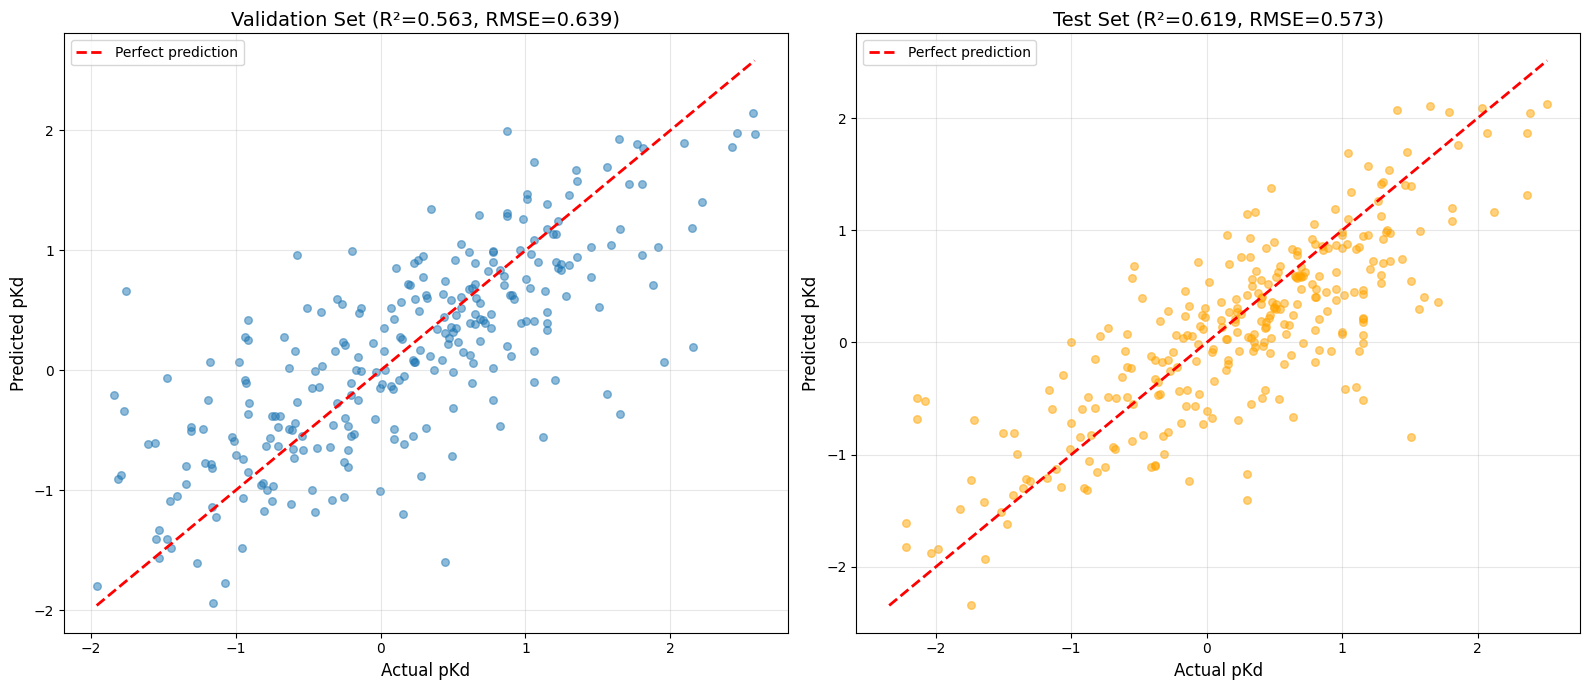


ERROR ANALYSIS

Residual Statistics:
  Mean error: -0.1319
  Std of errors: 0.5575
  Max overestimation: 1.6430
  Max underestimation: -2.3475

Top 10 Worst Predictions:
Index    Actual     Predicted    Error     
---------------------------------------------
65       1.706      0.360        -1.346    
125      1.021      -0.418       -1.440    
128      -2.141     -0.681       1.460     
47       0.296      -1.172       -1.468    
227      1.102      -0.399       -1.501    
264      -2.080     -0.519       1.561     
122      -2.136     -0.493       1.643     
78       1.152      -0.511       -1.663    
114      0.296      -1.405       -1.701    
175      1.510      -0.838       -2.348    

Residual plot saved as 'residual_plot.png'


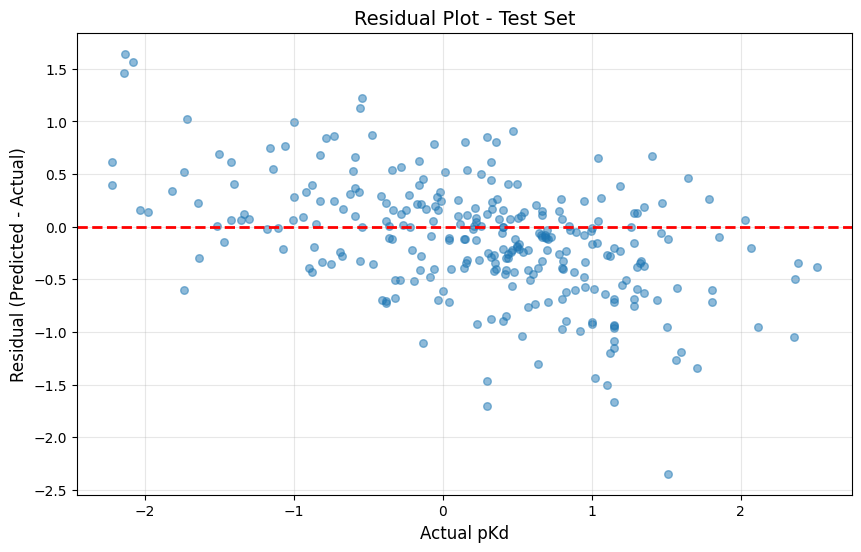


SAVING MODEL
Model saved as 'graphdock_model.pt'

COMPLETE!


In [ ]:
if __name__ == "__main__":
    # Enable GPU in Colab
    import torch
    if torch.cuda.is_available():
        print(f"GPU available: {torch.cuda.get_device_name(0)}")
        device = 'cuda'
    else:
        print("No GPU available, using CPU")
        device = 'cpu'

    # Step 1: Load Data
    print("="*60)
    print("LOADING PDBBIND DATASET")
    print("="*60)

    tasks, datasets, transformers = dc.molnet.load_pdbbind(
        featurizer='raw',
        set_name='refined',
        splitter='random',
        reload=True
    )
    train_dataset, valid_dataset, test_dataset = datasets

    print(f"Train: {len(train_dataset)}, Valid: {len(valid_dataset)}, Test: {len(test_dataset)}")

    print("\n" + "="*60)
    print("USING GRAPHDOCK APPROACH")
    print("="*60)

    print("\nProcessing training set...")
    train_graphs = process_pdbbind_with_graphdock(
        train_dataset,
        ligand_cutoff=5.0,
        protein_cutoff=6.0,
        interaction_cutoff=5.0
    )

    print("Processing validation set...")
    valid_graphs = process_pdbbind_with_graphdock(
        valid_dataset,
        ligand_cutoff=5.0,
        protein_cutoff=6.0,
        interaction_cutoff=5.0
    )

    print("Processing test set...")
    test_graphs = process_pdbbind_with_graphdock(
        test_dataset,
        ligand_cutoff=5.0,
        protein_cutoff=6.0,
        interaction_cutoff=5.0
    )

    BATCH_SIZE = 16
    train_loader = DataLoader(train_graphs, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(valid_graphs, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_graphs, batch_size=BATCH_SIZE, shuffle=False)

    model = GraphDockModel(
        ligand_feat_dim=18,
        protein_feat_dim=9,
        edge_feat_dim=14,
        hidden_dim=128,
        num_layers=3,
        output_dim=1,
        dropout=0.2
    )

    train_function = train_graphdock_model

    print(f"\nDataLoaders created with batch_size={BATCH_SIZE}")
    print(f"Training batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    print(f"Test batches: {len(test_loader)}")

    # Step 4: Display Model Architecture
    print("\n" + "="*60)
    print("MODEL ARCHITECTURE")
    print("="*60)
    print(model)
    print("\nTotal parameters:", sum(p.numel() for p in model.parameters()))
    print("Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

    # Step 5: Train Model
    print("\n" + "="*60)
    print("TRAINING")
    print("="*60)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    trained_model = train_function(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=200,
        patience=25,
        lr=0.001,
        device=device
    )

    # Step 6: Evaluate Model
    print("\n" + "="*60)
    print("EVALUATION")
    print("="*60)

    print("\nValidation Set Performance:")
    val_mse, val_rmse, val_r2, val_actuals, val_preds = evaluate_model(
        trained_model, val_loader, device=device
    )
    print(f"  MSE: {val_mse:.4f}")
    print(f"  RMSE: {val_rmse:.4f}")
    print(f"  R²: {val_r2:.4f}")

    print("\nTest Set Performance:")
    test_mse, test_rmse, test_r2, test_actuals, test_preds = evaluate_model(
        trained_model, test_loader, device=device
    )
    print(f"  MSE: {test_mse:.4f}")
    print(f"  RMSE: {test_rmse:.4f}")
    print(f"  R²: {test_r2:.4f}")

    # Step 7: Result Visualization
    print("\n" + "="*60)
    print("VISUALIZATION")
    print("="*60)

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # Validation set
    axes[0].scatter(val_actuals, val_preds, alpha=0.5, s=30)
    axes[0].set_xlabel("Actual pKd", fontsize=12)
    axes[0].set_ylabel("Predicted pKd", fontsize=12)
    axes[0].set_title(f"Validation Set (R²={val_r2:.3f}, RMSE={val_rmse:.3f})", fontsize=14)
    axes[0].grid(True, alpha=0.3)

    val_min = min(val_actuals.min(), val_preds.min())
    val_max = max(val_actuals.max(), val_preds.max())
    axes[0].plot([val_min, val_max], [val_min, val_max], 'r--', linewidth=2, label='Perfect prediction')
    axes[0].legend()

    # Test set
    axes[1].scatter(test_actuals, test_preds, alpha=0.5, s=30, color='orange')
    axes[1].set_xlabel("Actual pKd", fontsize=12)
    axes[1].set_ylabel("Predicted pKd", fontsize=12)
    axes[1].set_title(f"Test Set (R²={test_r2:.3f}, RMSE={test_rmse:.3f})", fontsize=14)
    axes[1].grid(True, alpha=0.3)

    test_min = min(test_actuals.min(), test_preds.min())
    test_max = max(test_actuals.max(), test_preds.max())
    axes[1].plot([test_min, test_max], [test_min, test_max], 'r--', linewidth=2, label='Perfect prediction')
    axes[1].legend()

    plt.tight_layout()
    plt.savefig('binding_affinity_predictions.png', dpi=300, bbox_inches='tight')
    print("Plot saved as 'binding_affinity_predictions.png'")
    plt.show()

    # Step 8: Error Analysis
    print("\n" + "="*60)
    print("ERROR ANALYSIS")
    print("="*60)

    test_residuals = test_preds - test_actuals

    print(f"\nResidual Statistics:")
    print(f"  Mean error: {test_residuals.mean():.4f}")
    print(f"  Std of errors: {test_residuals.std():.4f}")
    print(f"  Max overestimation: {test_residuals.max():.4f}")
    print(f"  Max underestimation: {test_residuals.min():.4f}")

    worst_indices = np.argsort(np.abs(test_residuals))[-10:]
    print(f"\nTop 10 Worst Predictions:")
    print(f"{'Index':<8} {'Actual':<10} {'Predicted':<12} {'Error':<10}")
    print("-" * 45)
    for idx in worst_indices:
        print(f"{idx:<8} {test_actuals[idx]:<10.3f} {test_preds[idx]:<12.3f} {test_residuals[idx]:<10.3f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(test_actuals, test_residuals, alpha=0.5, s=30)
    plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
    plt.xlabel("Actual pKd", fontsize=12)
    plt.ylabel("Residual (Predicted - Actual)", fontsize=12)
    plt.title("Residual Plot - Test Set", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.savefig('residual_plot.png', dpi=300, bbox_inches='tight')
    print("\nResidual plot saved as 'residual_plot.png'")
    plt.show()

    # Step 9: Save Model
    print("\n" + "="*60)
    print("SAVING MODEL")
    print("="*60)

    model_name = "pignet_model.pt" if USE_PIGNET else "graphdock_model.pt"
    torch.save({
        'model_state_dict': trained_model.state_dict(),
        'model_config': {
            'approach': 'PIGNet' if USE_PIGNET else 'GraphDock',
            'batch_size': BATCH_SIZE,
            'hidden_dim': 128,
        },
        'performance': {
            'test_mse': test_mse,
            'test_rmse': test_rmse,
            'test_r2': test_r2,
            'val_mse': val_mse,
            'val_rmse': val_rmse,
            'val_r2': val_r2,
        }
    }, model_name)

    print(f"Model saved as '{model_name}'")
    print("\n" + "="*60)
    print("COMPLETE!")
    print("="*60)

Model Comparison

In [ ]:
graphdock = torch.load('graphdock_model.pt', weights_only=False)

# Extract performance metrics
results = {
    'Model': ['PIGNet', 'GraphDock'],
    'Approach': [pignet['model_config']['approach'], graphdock['model_config']['approach']],
    'Batch Size': [pignet['model_config']['batch_size'], graphdock['model_config']['batch_size']],

    # Validation metrics
    'Val RMSE': [pignet['performance']['val_rmse'], graphdock['performance']['val_rmse']],
    'Val MSE': [pignet['performance']['val_mse'], graphdock['performance']['val_mse']],
    'Val R²': [pignet['performance']['val_r2'], graphdock['performance']['val_r2']],

    # Test metrics
    'Test RMSE': [pignet['performance']['test_rmse'], graphdock['performance']['test_rmse']],
    'Test MSE': [pignet['performance']['test_mse'], graphdock['performance']['test_mse']],
    'Test R²': [pignet['performance']['test_r2'], graphdock['performance']['test_r2']],
}

# Create DataFrame
df = pd.DataFrame(results)

print("="*80)
print("MODEL COMPARISON")
print("="*80)
print(df.to_string(index=False))

print("\n" + "="*80)
print("SUMMARY")
print("="*80)

# Find best model
best_test_rmse = df.loc[df['Test RMSE'].idxmin(), 'Model']
best_test_r2 = df.loc[df['Test R²'].idxmax(), 'Model']

print(f"\nBest Test RMSE: {best_test_rmse} ({df['Test RMSE'].min():.4f})")
print(f"Best Test R²: {best_test_r2} ({df['Test R²'].max():.4f})")

print(f"\nRMSE Difference: {abs(df['Test RMSE'][0] - df['Test RMSE'][1]):.4f}")
print(f"R² Difference: {abs(df['Test R²'][0] - df['Test R²'][1]):.4f}")

MODEL COMPARISON
    Model  Approach  Batch Size  Val RMSE  Val MSE   Val R²  Test RMSE  Test MSE  Test R²
   PIGNet    PIGNet          32  0.646198 0.417572 0.553261   0.688319  0.473783 0.450063
GraphDock GraphDock          16  0.638776 0.408034 0.563465   0.572918  0.328235 0.619006

SUMMARY

Best Test RMSE: GraphDock (0.5729)
Best Test R²: GraphDock (0.6190)

RMSE Difference: 0.1154
R² Difference: 0.1689
